# 15. Advanced Statistical Modeling
## STAT495 - Turkey Earthquake Data (1990-2025)

This notebook addresses additional research questions (A-I categories) using advanced statistical models.

### Research Question Categories

**A. Earthquakes - Spatial & Behavioral**
- A1: Spatial clustering of major earthquakes
- A2: Regional aftershock behavior differences
- A3: Shallow depth-magnitude relationship

**B. Active Faults**
- B1: Non-linear fault distance-magnitude relationship
- B2: Fault type magnitude distribution differences

**C. Soil Types**
- C2: Soft soil amplification effects
- C3: Depth-soil type relationship

**D. Atmospheric Pressure**
- D1: Pressure anomalies and daily earthquake count
- D2: Low pressure and major earthquake probability

**E. Moon Phases**
- E1: Non-linear moon age effect
- E2: Perigee and major earthquake frequency

**F. Solar & Lunar Eclipses**
- F1: Eclipse day earthquake rate increase
- F2: Eclipse type and earthquake probability

**G. GPS Velocities**
- G1: High GPS velocity and earthquake frequency
- G2: Strain rate as magnitude predictor

**I. Pressure Anomalies**
- I1: Extreme anomaly days and earthquake deviation
- I2: Pressure anomaly × moon phase interaction

---
## 1. Setup and Data Preparation

In [1]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Statistical modeling
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.discrete.discrete_model import Logit, Poisson, NegativeBinomialP
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod import families

# Sklearn for metrics and clustering
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

# Statistical tests
from scipy import stats
from scipy.stats import chi2_contingency, kruskal, mannwhitneyu, fisher_exact, binom
from scipy.spatial.distance import pdist, squareform

# Add src to path
import sys
sys.path.append('..')
from src.config import *

# Plot settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = FIGURE_SIZE_DEFAULT
plt.rcParams['figure.dpi'] = FIGURE_DPI
plt.rcParams['font.size'] = FONT_SIZE

print("Libraries loaded successfully!")

Libraries loaded successfully!


In [2]:
# Output paths
OUTPUT_DIR = os.path.join(FIGURES_PATH, '15_advanced_modeling')
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f"Output directory: {OUTPUT_DIR}")

Output directory: /Users/boraesen/Desktop/Semester 7/Stat495/stat495project/reports/figures/15_advanced_modeling


In [3]:
# Load processed earthquake data
df = pd.read_csv(os.path.join(DATA_PROCESSED, 'earthquakes_processed.csv'), low_memory=False)
df['date'] = pd.to_datetime(df['date'], format='mixed')
df['date_only'] = pd.to_datetime(df['date_only'], format='mixed')
print(f"Loaded {len(df):,} earthquake records")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")

Loaded 524,952 earthquake records
Date range: 1990-01-03 13:30:14 to 2025-11-20 16:51:56


In [4]:
# Load eclipse data
solar_eclipses = pd.read_csv(os.path.join(DATA_PROCESSED, 'solar_eclipses.csv'), 
                              parse_dates=['date'])
lunar_eclipses = pd.read_csv(os.path.join(DATA_PROCESSED, 'lunar_eclipses.csv'),
                              parse_dates=['date'])
all_eclipses = pd.read_csv(os.path.join(DATA_PROCESSED, 'all_eclipses.csv'),
                            parse_dates=['date'])

print(f"Solar eclipses: {len(solar_eclipses)}")
print(f"Lunar eclipses: {len(lunar_eclipses)}")
print(f"Total eclipses: {len(all_eclipses)}")

Solar eclipses: 79
Lunar eclipses: 82
Total eclipses: 161


In [5]:
# Create derived variables
df['is_major_45'] = (df['magnitude'] >= 4.5).astype(int)
df['is_major_50'] = (df['magnitude'] >= 5.0).astype(int)
df['is_shallow'] = (df['depth'] < 20).astype(int)

# Pressure anomaly (z-score)
if 'pressure_hpa' in df.columns:
    df['pressure_zscore'] = (df['pressure_hpa'] - df['pressure_hpa'].mean()) / df['pressure_hpa'].std()
    df['is_pressure_extreme'] = (np.abs(df['pressure_zscore']) > 2).astype(int)

print("Derived variables created.")
print(f"\nMajor earthquakes (M>=4.5): {df['is_major_45'].sum():,}")
print(f"Major earthquakes (M>=5.0): {df['is_major_50'].sum():,}")
print(f"Shallow events (<20km): {df['is_shallow'].sum():,}")

Derived variables created.

Major earthquakes (M>=4.5): 1,147
Major earthquakes (M>=5.0): 362
Shallow events (<20km): 511,416


---
## 2. RQ-A: Spatial Clustering & Aftershock Analysis

### A1: Is there significant spatial clustering of major earthquakes?

In [6]:
# A1: DBSCAN Clustering of Major Earthquakes
major_eq = df[df['is_major_45'] == 1][['latitude', 'longitude', 'magnitude', 'date']].copy()
print(f"Major earthquakes for clustering: {len(major_eq)}")

# DBSCAN with geographic distance
# eps is in degrees, roughly 0.5 degrees ~ 50km
coords = major_eq[['latitude', 'longitude']].values

# Run DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5, metric='haversine')
# Convert to radians for haversine
coords_rad = np.radians(coords)
major_eq['cluster'] = dbscan.fit_predict(coords_rad)

n_clusters = len(set(major_eq['cluster'])) - (1 if -1 in major_eq['cluster'].values else 0)
n_noise = (major_eq['cluster'] == -1).sum()

print(f"\nDBSCAN Results:")
print(f"Number of clusters: {n_clusters}")
print(f"Noise points: {n_noise} ({100*n_noise/len(major_eq):.1f}%)")
print(f"Clustered points: {len(major_eq) - n_noise} ({100*(len(major_eq)-n_noise)/len(major_eq):.1f}%)")

Major earthquakes for clustering: 1147

DBSCAN Results:
Number of clusters: 1
Noise points: 0 (0.0%)
Clustered points: 1147 (100.0%)


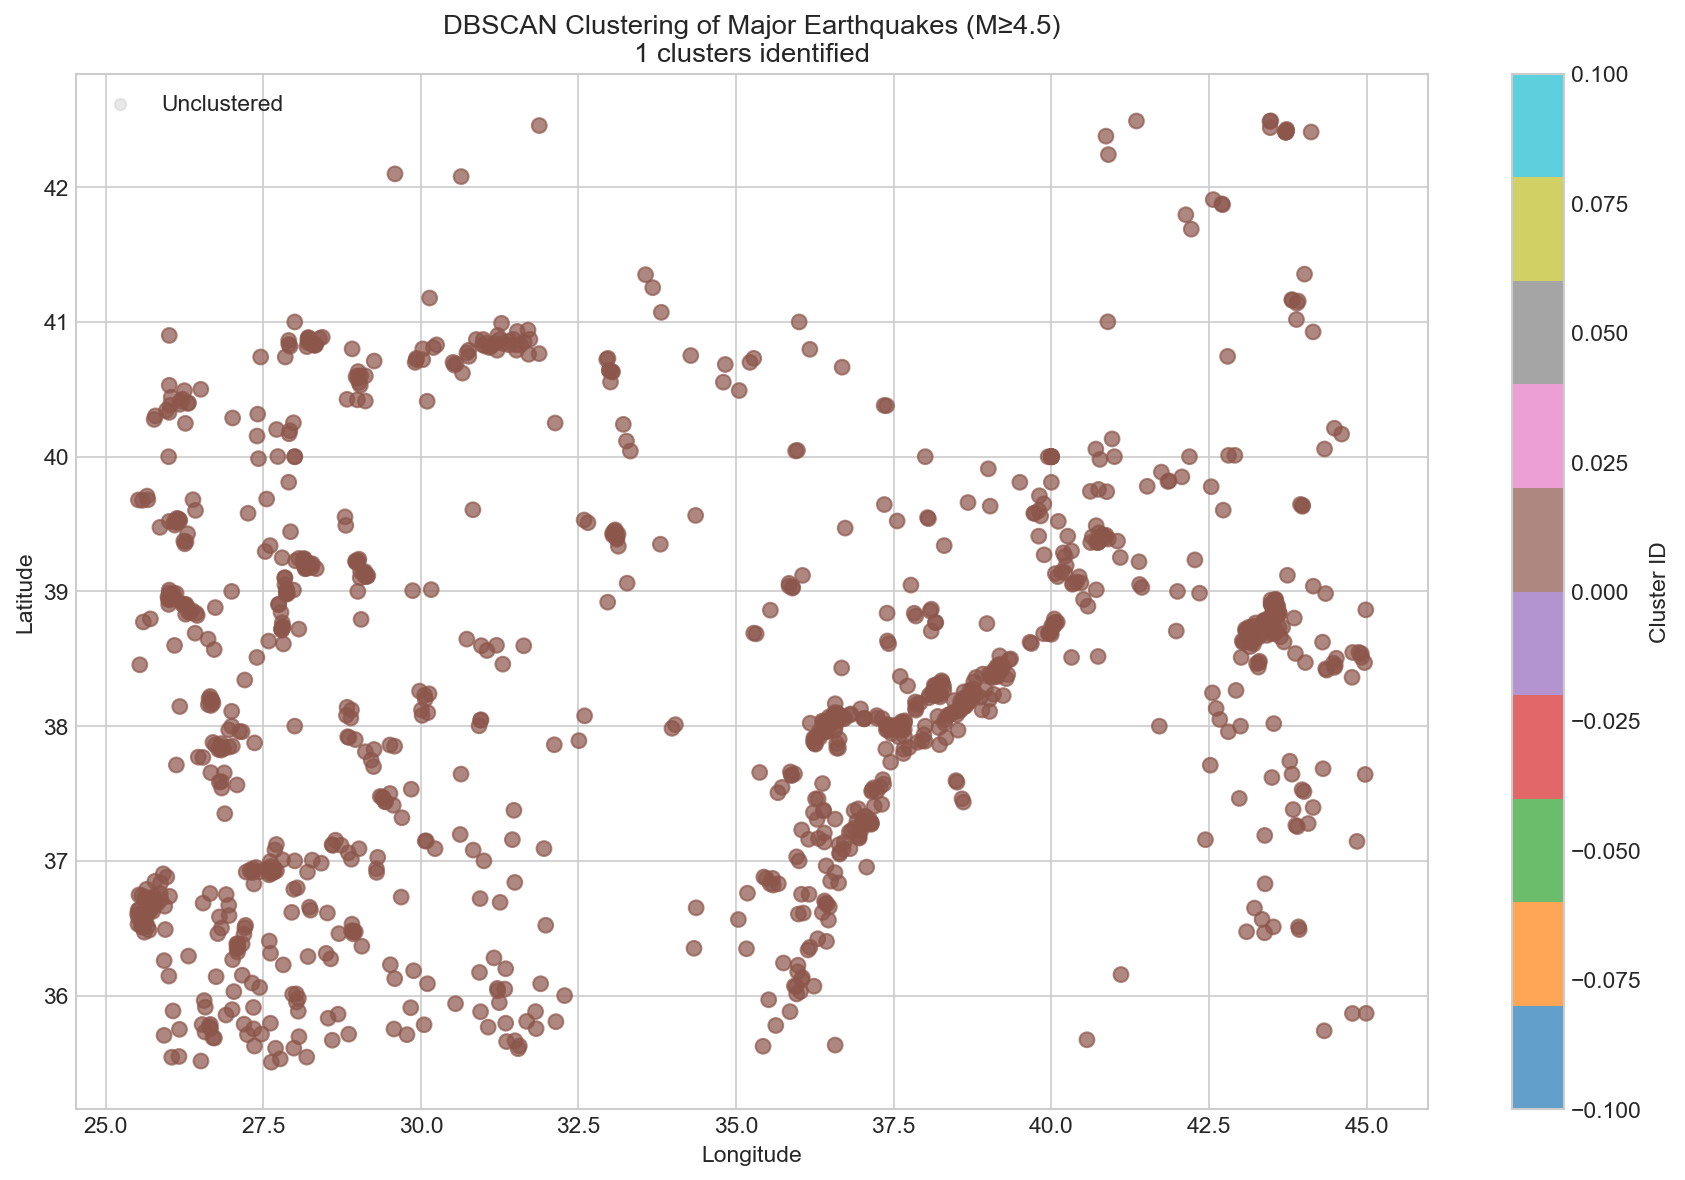

In [7]:
# Visualize clusters
fig, ax = plt.subplots(figsize=(12, 8))

# Plot noise points
noise = major_eq[major_eq['cluster'] == -1]
ax.scatter(noise['longitude'], noise['latitude'], c='lightgray', s=30, 
           alpha=0.5, label='Unclustered')

# Plot clusters
clustered = major_eq[major_eq['cluster'] != -1]
scatter = ax.scatter(clustered['longitude'], clustered['latitude'], 
                     c=clustered['cluster'], cmap='tab10', s=50, alpha=0.7)

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title(f'DBSCAN Clustering of Major Earthquakes (M≥4.5)\n{n_clusters} clusters identified')
ax.legend()
plt.colorbar(scatter, label='Cluster ID')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'a1_spatial_clustering.png'), dpi=300, bbox_inches='tight')
plt.show()

In [8]:
# A1 Statistical Test: Compare clustered vs random distribution
# Using Monte Carlo approach
from scipy.stats import ks_2samp

n_simulations = 1000
observed_cluster_ratio = (len(major_eq) - n_noise) / len(major_eq)

# Simulate random points within Turkey's bounding box
lat_min, lat_max = df['latitude'].min(), df['latitude'].max()
lon_min, lon_max = df['longitude'].min(), df['longitude'].max()

random_cluster_ratios = []
for _ in range(n_simulations):
    random_coords = np.column_stack([
        np.random.uniform(lat_min, lat_max, len(major_eq)),
        np.random.uniform(lon_min, lon_max, len(major_eq))
    ])
    random_coords_rad = np.radians(random_coords)
    random_clusters = dbscan.fit_predict(random_coords_rad)
    random_noise = (random_clusters == -1).sum()
    random_cluster_ratios.append((len(major_eq) - random_noise) / len(major_eq))

# P-value: proportion of random simulations with equal or higher clustering
p_value = np.mean([r >= observed_cluster_ratio for r in random_cluster_ratios])

print(f"\nA1 Statistical Test:")
print(f"Observed cluster ratio: {observed_cluster_ratio:.3f}")
print(f"Mean random cluster ratio: {np.mean(random_cluster_ratios):.3f}")
print(f"P-value (Monte Carlo): {p_value:.4f}")
print(f"Conclusion: {'Significant clustering' if p_value < 0.05 else 'No significant clustering'} (α=0.05)")


A1 Statistical Test:
Observed cluster ratio: 1.000
Mean random cluster ratio: 1.000
P-value (Monte Carlo): 1.0000
Conclusion: No significant clustering (α=0.05)


### A3: Do shallow earthquakes (<20km) have larger magnitudes?

In [9]:
# A3: Mann-Whitney U Test for shallow vs deep earthquake magnitudes
shallow = df[df['depth'] < 20]['magnitude']
deep = df[df['depth'] >= 20]['magnitude']

print(f"Shallow earthquakes (<20km): n={len(shallow):,}")
print(f"  Mean magnitude: {shallow.mean():.3f}")
print(f"  Median magnitude: {shallow.median():.3f}")
print(f"\nDeep earthquakes (>=20km): n={len(deep):,}")
print(f"  Mean magnitude: {deep.mean():.3f}")
print(f"  Median magnitude: {deep.median():.3f}")

# Mann-Whitney U test
stat, p_value = mannwhitneyu(shallow, deep, alternative='greater')
print(f"\nMann-Whitney U Test (one-sided):")
print(f"U-statistic: {stat:,.0f}")
print(f"P-value: {p_value:.4e}")
print(f"Conclusion: {'Shallow earthquakes are significantly larger' if p_value < 0.05 else 'No significant difference'} (α=0.05)")

Shallow earthquakes (<20km): n=511,416
  Mean magnitude: 1.964
  Median magnitude: 1.800

Deep earthquakes (>=20km): n=13,536
  Mean magnitude: 2.615
  Median magnitude: 2.700

Mann-Whitney U Test (one-sided):
U-statistic: 1,836,033,938
P-value: 1.0000e+00
Conclusion: No significant difference (α=0.05)


In [10]:
# A3: Logistic regression for major earthquake probability by depth
model_data = df[['magnitude', 'depth', 'is_major_45']].dropna()

# Logistic regression
X = sm.add_constant(model_data[['depth']])
y = model_data['is_major_45']

logit_model = sm.Logit(y, X).fit(disp=0)
print("\nA3: Logistic Regression (Major earthquake ~ Depth)")
print(logit_model.summary().tables[1])

# Odds ratio
odds_ratio = np.exp(logit_model.params['depth'])
print(f"\nOdds Ratio (per 1km increase in depth): {odds_ratio:.4f}")
print(f"Interpretation: Each 1km increase in depth changes major earthquake odds by {(odds_ratio-1)*100:.2f}%")


A3: Logistic Regression (Major earthquake ~ Depth)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -6.5071      0.035   -184.401      0.000      -6.576      -6.438
depth          0.0396      0.001     26.813      0.000       0.037       0.042

Odds Ratio (per 1km increase in depth): 1.0404
Interpretation: Each 1km increase in depth changes major earthquake odds by 4.04%


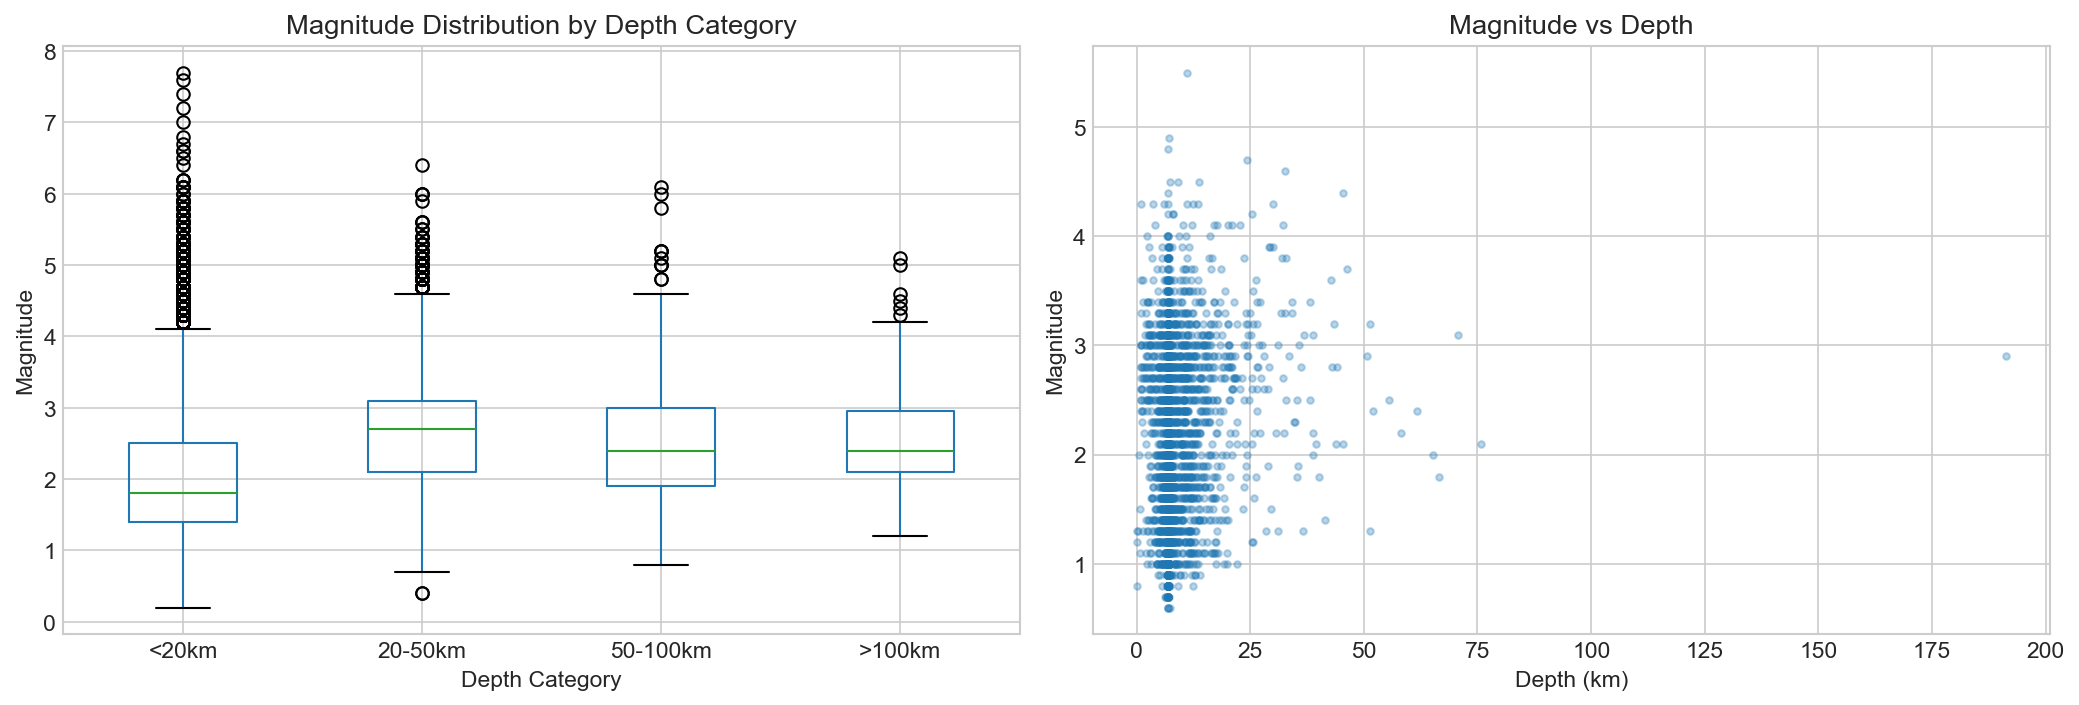

In [11]:
# Visualization: Magnitude vs Depth
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Box plot
ax1 = axes[0]
df['depth_category'] = pd.cut(df['depth'], bins=[0, 20, 50, 100, 700], 
                               labels=['<20km', '20-50km', '50-100km', '>100km'])
df.boxplot(column='magnitude', by='depth_category', ax=ax1)
ax1.set_xlabel('Depth Category')
ax1.set_ylabel('Magnitude')
ax1.set_title('Magnitude Distribution by Depth Category')
plt.suptitle('')

# Scatter with regression line
ax2 = axes[1]
sample = df.sample(min(5000, len(df)))
ax2.scatter(sample['depth'], sample['magnitude'], alpha=0.3, s=10)
ax2.set_xlabel('Depth (km)')
ax2.set_ylabel('Magnitude')
ax2.set_title('Magnitude vs Depth')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'a3_depth_magnitude.png'), dpi=300, bbox_inches='tight')
plt.show()

---
## 3. RQ-B: Fault Type Effects

### B1: Is the fault distance-magnitude relationship non-linear?

In [12]:
# B1: Compare linear vs polynomial models
model_data = df[['magnitude', 'fault_distance_km']].dropna()
model_data = model_data[model_data['fault_distance_km'] < 100]  # Limit to 100km

print(f"Data points for analysis: {len(model_data):,}")

# Create polynomial features
model_data['fault_dist_sq'] = model_data['fault_distance_km'] ** 2
model_data['fault_dist_cb'] = model_data['fault_distance_km'] ** 3

# Linear model
X_linear = sm.add_constant(model_data[['fault_distance_km']])
y = model_data['magnitude']
linear_model = sm.OLS(y, X_linear).fit()

# Quadratic model
X_quad = sm.add_constant(model_data[['fault_distance_km', 'fault_dist_sq']])
quad_model = sm.OLS(y, X_quad).fit()

# Cubic model
X_cubic = sm.add_constant(model_data[['fault_distance_km', 'fault_dist_sq', 'fault_dist_cb']])
cubic_model = sm.OLS(y, X_cubic).fit()

print("\nB1: Model Comparison")
print(f"{'Model':<15} {'AIC':>12} {'BIC':>12} {'R²':>10}")
print("-" * 50)
print(f"{'Linear':<15} {linear_model.aic:>12.1f} {linear_model.bic:>12.1f} {linear_model.rsquared:>10.6f}")
print(f"{'Quadratic':<15} {quad_model.aic:>12.1f} {quad_model.bic:>12.1f} {quad_model.rsquared:>10.6f}")
print(f"{'Cubic':<15} {cubic_model.aic:>12.1f} {cubic_model.bic:>12.1f} {cubic_model.rsquared:>10.6f}")

Data points for analysis: 2,683

B1: Model Comparison
Model                    AIC          BIC         R²
--------------------------------------------------
Linear                2845.3       2857.1   0.000097
Quadratic             2843.3       2860.9   0.001599
Cubic                 2845.2       2868.8   0.001602


In [13]:
# F-test for model comparison (linear vs quadratic)
from scipy.stats import f as f_dist

# RSS comparison
rss_linear = linear_model.ssr
rss_quad = quad_model.ssr

df1 = quad_model.df_model - linear_model.df_model  # Difference in parameters
df2 = quad_model.df_resid

f_stat = ((rss_linear - rss_quad) / df1) / (rss_quad / df2)
p_value = 1 - f_dist.cdf(f_stat, df1, df2)

print(f"\nF-test (Linear vs Quadratic):")
print(f"F-statistic: {f_stat:.4f}")
print(f"P-value: {p_value:.4e}")
print(f"Conclusion: {'Quadratic model significantly better' if p_value < 0.05 else 'Linear model sufficient'} (α=0.05)")


F-test (Linear vs Quadratic):
F-statistic: 4.0307
P-value: 4.4779e-02
Conclusion: Quadratic model significantly better (α=0.05)


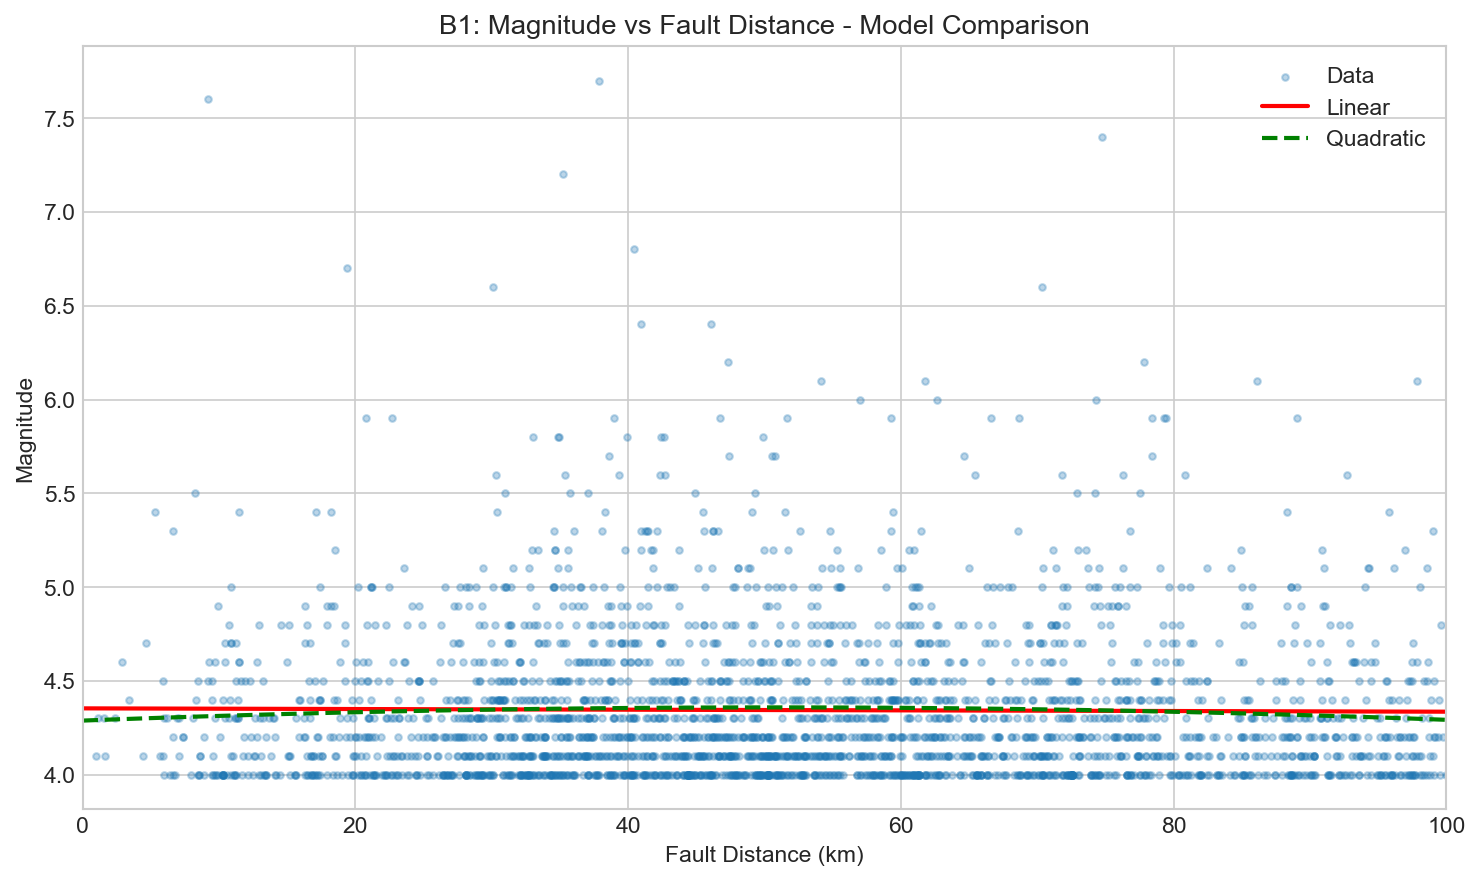

In [14]:
# Visualization
fig, ax = plt.subplots(figsize=(10, 6))

# Sample for visualization
sample = model_data.sample(min(5000, len(model_data)))
ax.scatter(sample['fault_distance_km'], sample['magnitude'], alpha=0.3, s=10, label='Data')

# Plot fitted curves
x_range = np.linspace(0, 100, 100)
y_linear = linear_model.params['const'] + linear_model.params['fault_distance_km'] * x_range
y_quad = (quad_model.params['const'] + 
          quad_model.params['fault_distance_km'] * x_range + 
          quad_model.params['fault_dist_sq'] * x_range**2)

ax.plot(x_range, y_linear, 'r-', linewidth=2, label='Linear')
ax.plot(x_range, y_quad, 'g--', linewidth=2, label='Quadratic')

ax.set_xlabel('Fault Distance (km)')
ax.set_ylabel('Magnitude')
ax.set_title('B1: Magnitude vs Fault Distance - Model Comparison')
ax.legend()
ax.set_xlim(0, 100)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'b1_fault_distance_nonlinear.png'), dpi=300, bbox_inches='tight')
plt.show()

---
## 4. RQ-C: Soil-Depth Relationships

### C3: Is there a relationship between depth and soil type?

In [15]:
# C3: ANOVA - Depth by soil class
model_data = df[['depth', 'soil_class']].dropna()

# Group statistics
print("C3: Depth by Soil Class")
print(model_data.groupby('soil_class')['depth'].agg(['count', 'mean', 'std', 'median']))

# One-way ANOVA
groups = [group['depth'].values for name, group in model_data.groupby('soil_class')]
f_stat, p_value = stats.f_oneway(*groups)

print(f"\nOne-way ANOVA:")
print(f"F-statistic: {f_stat:.4f}")
print(f"P-value: {p_value:.4e}")
print(f"Conclusion: {'Significant depth differences by soil class' if p_value < 0.05 else 'No significant differences'} (α=0.05)")

C3: Depth by Soil Class


             count      mean       std  median
soil_class                                    
ZB          186701  7.784697  3.372471     7.0
ZC          283216  8.458106  6.528536     7.0
ZE           45172  7.813572  3.917601     7.0

One-way ANOVA:
F-statistic: 984.0261
P-value: 0.0000e+00
Conclusion: Significant depth differences by soil class (α=0.05)


In [16]:
# Chi-square test: Depth class vs Soil class
model_data = df[['depth_class', 'soil_class']].dropna()
contingency = pd.crosstab(model_data['depth_class'], model_data['soil_class'])

print("Contingency Table: Depth Class × Soil Class")
print(contingency)

chi2, p_value, dof, expected = chi2_contingency(contingency)
print(f"\nChi-square Test:")
print(f"χ² = {chi2:.2f}")
print(f"Degrees of freedom: {dof}")
print(f"P-value: {p_value:.4e}")
print(f"Conclusion: {'Significant association' if p_value < 0.05 else 'No significant association'} (α=0.05)")

Contingency Table: Depth Class × Soil Class
soil_class                   ZB      ZC     ZE
depth_class                                   
Deep (>70 km)                16     636      8
Intermediate (30-70 km)     368    3256    154
Shallow (10-30 km)        21500   34610   5371
Very Shallow (0-10 km)   164817  244714  39639

Chi-square Test:
χ² = 2046.71
Degrees of freedom: 6
P-value: 0.0000e+00
Conclusion: Significant association (α=0.05)


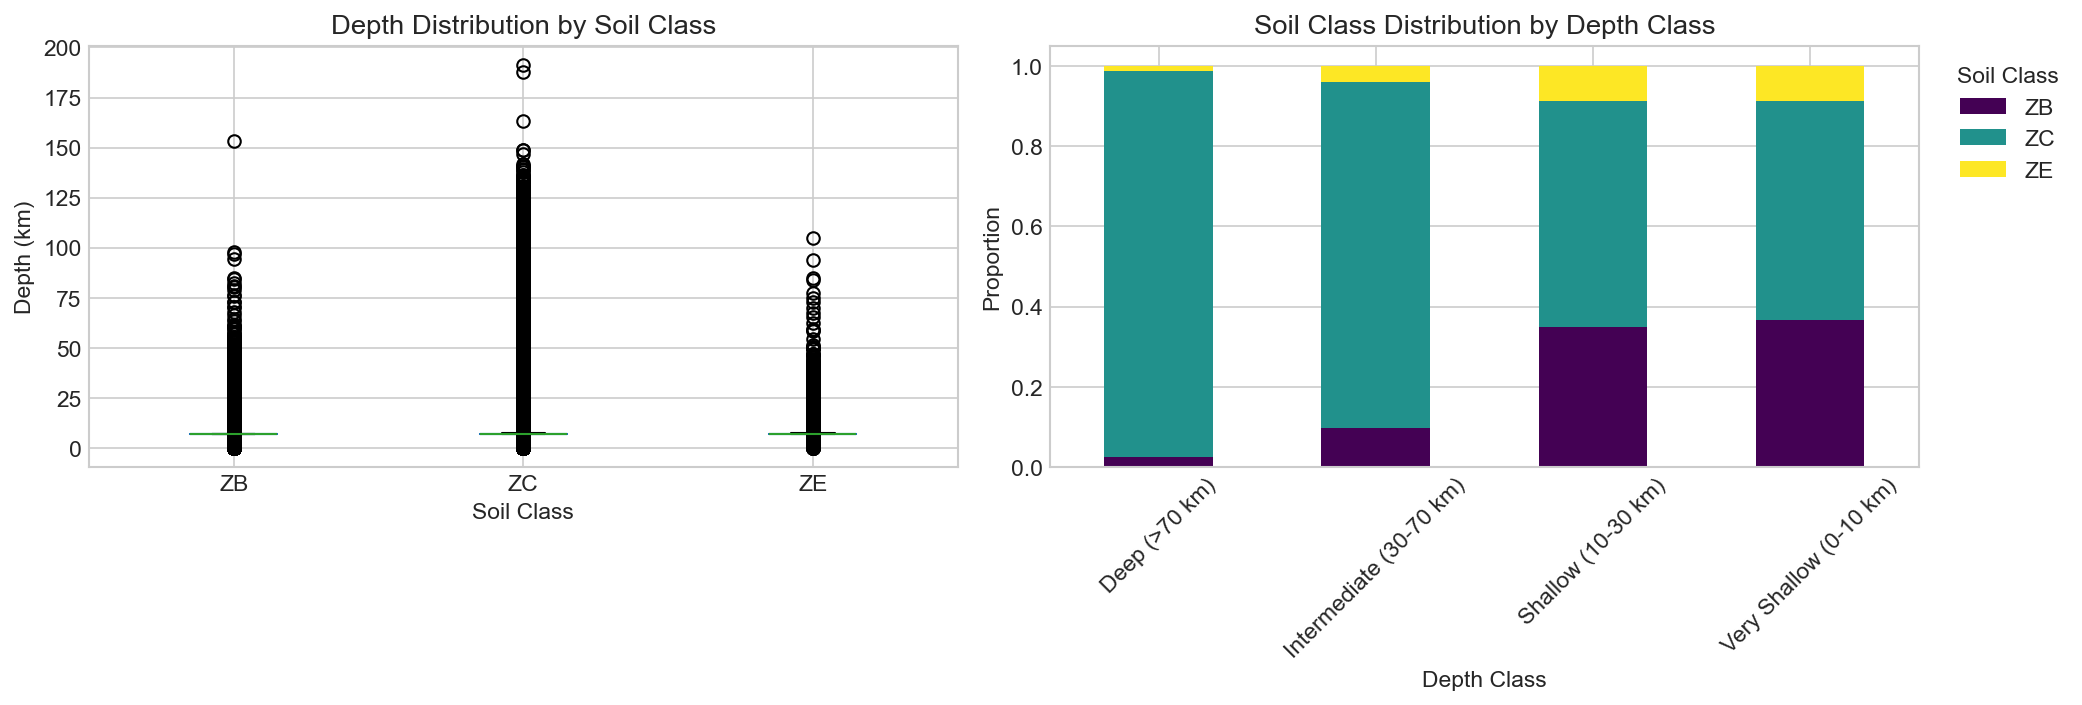

In [17]:
# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Box plot
ax1 = axes[0]
df.boxplot(column='depth', by='soil_class', ax=ax1)
ax1.set_xlabel('Soil Class')
ax1.set_ylabel('Depth (km)')
ax1.set_title('Depth Distribution by Soil Class')
plt.suptitle('')

# Stacked bar
ax2 = axes[1]
contingency_pct = contingency.div(contingency.sum(axis=1), axis=0)
contingency_pct.plot(kind='bar', stacked=True, ax=ax2, colormap='viridis')
ax2.set_xlabel('Depth Class')
ax2.set_ylabel('Proportion')
ax2.set_title('Soil Class Distribution by Depth Class')
ax2.legend(title='Soil Class', bbox_to_anchor=(1.02, 1))
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'c3_depth_soil.png'), dpi=300, bbox_inches='tight')
plt.show()

---
## 5. RQ-D: Atmospheric Pressure Effects

### D1: Do pressure anomalies affect daily earthquake count?

In [18]:
# D1: Aggregate daily data
daily_data = df.groupby('date_only').agg({
    'eventID': 'count',
    'pressure_hpa': 'mean',
    'pressure_zscore': 'mean',
    'is_pressure_extreme': 'max'
}).reset_index()
daily_data.columns = ['date', 'eq_count', 'pressure', 'pressure_zscore', 'is_extreme']
daily_data = daily_data.dropna()

print(f"Daily observations: {len(daily_data)}")
print(f"Mean daily earthquakes: {daily_data['eq_count'].mean():.2f}")
print(f"Std daily earthquakes: {daily_data['eq_count'].std():.2f}")

Daily observations: 10496
Mean daily earthquakes: 50.01
Std daily earthquakes: 62.44


In [19]:
# D1: Negative Binomial Regression (count model)
X = sm.add_constant(daily_data[['pressure_zscore']])
y = daily_data['eq_count']

# Poisson first to check overdispersion
poisson_model = sm.GLM(y, X, family=families.Poisson()).fit()
print("Poisson Model Summary:")
print(poisson_model.summary().tables[1])

# Check overdispersion
pearson_chi2 = poisson_model.pearson_chi2
dispersion = pearson_chi2 / poisson_model.df_resid
print(f"\nOverdispersion check:")
print(f"Dispersion ratio: {dispersion:.4f}")
print(f"{'Overdispersion detected - use Negative Binomial' if dispersion > 1.5 else 'Poisson adequate'}")

Poisson Model Summary:
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               3.9126      0.001   2834.802      0.000       3.910       3.915
pressure_zscore     0.0230      0.001     16.675      0.000       0.020       0.026

Overdispersion check:
Dispersion ratio: 77.7033
Overdispersion detected - use Negative Binomial


In [20]:
# If overdispersed, fit Negative Binomial
if dispersion > 1.5:
    nb_model = sm.GLM(y, X, family=families.NegativeBinomial(alpha=1)).fit()
    print("\nNegative Binomial Model Summary:")
    print(nb_model.summary().tables[1])
    
    # Rate ratio
    rate_ratio = np.exp(nb_model.params['pressure_zscore'])
    print(f"\nRate Ratio (per 1 SD pressure change): {rate_ratio:.4f}")
    print(f"95% CI: ({np.exp(nb_model.conf_int().loc['pressure_zscore', 0]):.4f}, "
          f"{np.exp(nb_model.conf_int().loc['pressure_zscore', 1]):.4f})")


Negative Binomial Model Summary:
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               3.9126      0.010    396.792      0.000       3.893       3.932
pressure_zscore     0.0230      0.010      2.333      0.020       0.004       0.042

Rate Ratio (per 1 SD pressure change): 1.0233
95% CI: (1.0037, 1.0433)


### D2: Is low pressure associated with higher major earthquake probability?

In [21]:
# D2: Logistic regression - Major earthquake vs pressure
model_data = df[['is_major_45', 'pressure_zscore', 'pressure_hpa']].dropna()

# Create low pressure indicator
model_data['is_low_pressure'] = (model_data['pressure_zscore'] < -1).astype(int)

# Logistic regression
X = sm.add_constant(model_data[['is_low_pressure']])
y = model_data['is_major_45']

logit_model = sm.Logit(y, X).fit(disp=0)
print("D2: Logistic Regression (Major earthquake ~ Low pressure)")
print(logit_model.summary().tables[1])

# Odds ratio
odds_ratio = np.exp(logit_model.params['is_low_pressure'])
ci = np.exp(logit_model.conf_int().loc['is_low_pressure'])
print(f"\nOdds Ratio: {odds_ratio:.4f}")
print(f"95% CI: ({ci[0]:.4f}, {ci[1]:.4f})")
print(f"P-value: {logit_model.pvalues['is_low_pressure']:.4f}")

D2: Logistic Regression (Major earthquake ~ Low pressure)


                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -6.0959      0.031   -194.184      0.000      -6.157      -6.034
is_low_pressure    -0.2238      0.093     -2.400      0.016      -0.407      -0.041

Odds Ratio: 0.7995
95% CI: (0.6660, 0.9598)
P-value: 0.0164


---
## 6. RQ-E: Non-linear Moon Effects

### E1: Is the moon age effect non-linear (new/full moon peaks)?

In [22]:
# E1: Polynomial regression for moon age effect
model_data = df[['is_major_45', 'moon_age']].dropna()

# Create polynomial and periodic features
model_data['moon_age_sq'] = model_data['moon_age'] ** 2
# Periodic terms (new moon at 0, full moon at 14.5)
model_data['sin_moon'] = np.sin(2 * np.pi * model_data['moon_age'] / 29.5)
model_data['cos_moon'] = np.cos(2 * np.pi * model_data['moon_age'] / 29.5)

# Linear model
X_linear = sm.add_constant(model_data[['moon_age']])
y = model_data['is_major_45']
linear_model = sm.Logit(y, X_linear).fit(disp=0)

# Quadratic model
X_quad = sm.add_constant(model_data[['moon_age', 'moon_age_sq']])
quad_model = sm.Logit(y, X_quad).fit(disp=0)

# Periodic model
X_periodic = sm.add_constant(model_data[['sin_moon', 'cos_moon']])
periodic_model = sm.Logit(y, X_periodic).fit(disp=0)

print("E1: Model Comparison (Moon Age → Major Earthquake)")
print(f"{'Model':<15} {'AIC':>12} {'BIC':>12} {'Pseudo-R²':>12}")
print("-" * 55)
print(f"{'Linear':<15} {linear_model.aic:>12.1f} {linear_model.bic:>12.1f} {linear_model.prsquared:>12.6f}")
print(f"{'Quadratic':<15} {quad_model.aic:>12.1f} {quad_model.bic:>12.1f} {quad_model.prsquared:>12.6f}")
print(f"{'Periodic':<15} {periodic_model.aic:>12.1f} {periodic_model.bic:>12.1f} {periodic_model.prsquared:>12.6f}")

E1: Model Comparison (Moon Age → Major Earthquake)
Model                    AIC          BIC    Pseudo-R²
-------------------------------------------------------


Linear               16327.0      16349.3     0.001343


Quadratic            16317.6      16351.2     0.002035


Periodic             16339.2      16372.7     0.000718


In [23]:
# Likelihood ratio test: Linear vs Periodic
lr_stat = 2 * (periodic_model.llf - linear_model.llf)
p_value = 1 - stats.chi2.cdf(lr_stat, df=1)  # 1 extra parameter

print(f"\nLikelihood Ratio Test (Linear vs Periodic):")
print(f"LR statistic: {lr_stat:.4f}")
print(f"P-value: {p_value:.4f}")
print(f"Conclusion: {'Periodic model significantly better' if p_value < 0.05 else 'Linear model sufficient'} (α=0.05)")


Likelihood Ratio Test (Linear vs Periodic):
LR statistic: -10.2134
P-value: 1.0000
Conclusion: Linear model sufficient (α=0.05)


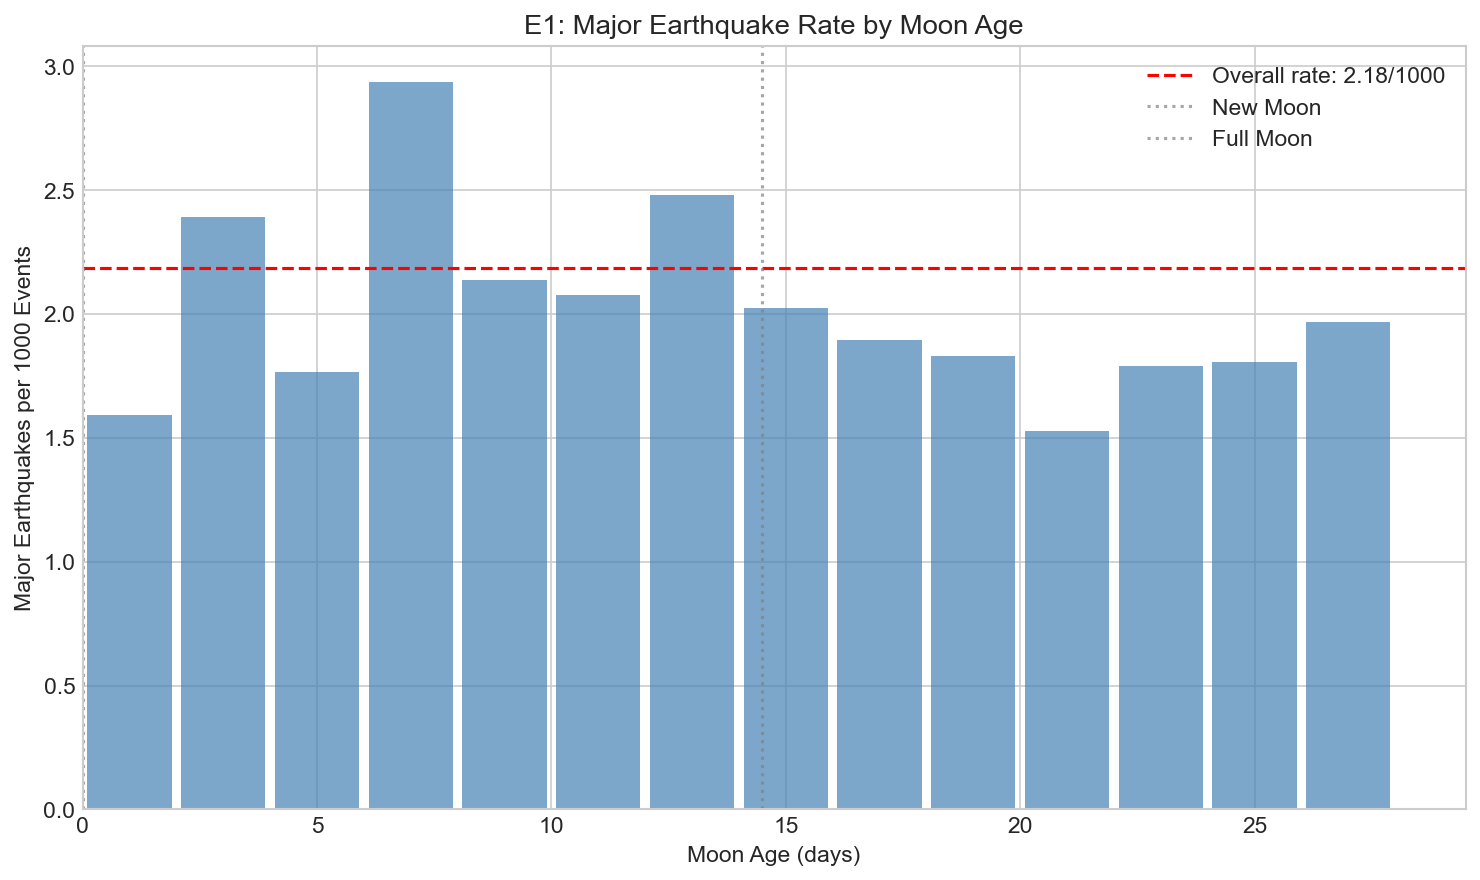

In [24]:
# Visualization
fig, ax = plt.subplots(figsize=(10, 6))

# Aggregate by moon age bins
bins = np.arange(0, 30, 2)
model_data['moon_age_bin'] = pd.cut(model_data['moon_age'], bins=bins)
agg = model_data.groupby('moon_age_bin')['is_major_45'].agg(['sum', 'count']).reset_index()
agg['rate'] = agg['sum'] / agg['count'] * 1000  # per 1000 events
agg['mid'] = [(b.left + b.right) / 2 for b in agg['moon_age_bin']]

ax.bar(agg['mid'], agg['rate'], width=1.8, alpha=0.7, color='steelblue')
ax.axhline(y=model_data['is_major_45'].mean() * 1000, color='red', linestyle='--', 
           label=f'Overall rate: {model_data["is_major_45"].mean()*1000:.2f}/1000')
ax.axvline(x=0, color='gray', linestyle=':', alpha=0.7, label='New Moon')
ax.axvline(x=14.5, color='gray', linestyle=':', alpha=0.7, label='Full Moon')

ax.set_xlabel('Moon Age (days)')
ax.set_ylabel('Major Earthquakes per 1000 Events')
ax.set_title('E1: Major Earthquake Rate by Moon Age')
ax.legend()
ax.set_xlim(0, 29.5)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'e1_moon_age_nonlinear.png'), dpi=300, bbox_inches='tight')
plt.show()

---
## 7. RQ-F: Eclipse Day Analysis

### F1: Is there an increase in earthquakes on eclipse days?

In [25]:
# F1: Mark eclipse days in daily data
eclipse_dates = set(all_eclipses['date'].dt.date)

# Daily earthquake counts
daily_counts = df.groupby('date_only').size().reset_index(name='eq_count')
daily_counts['is_eclipse'] = daily_counts['date_only'].dt.date.isin(eclipse_dates).astype(int)

print(f"Total days: {len(daily_counts)}")
print(f"Eclipse days: {daily_counts['is_eclipse'].sum()}")
print(f"Non-eclipse days: {(~daily_counts['is_eclipse'].astype(bool)).sum()}")

Total days: 10496
Eclipse days: 126
Non-eclipse days: 10370


In [26]:
# Compare earthquake counts
eclipse_counts = daily_counts[daily_counts['is_eclipse'] == 1]['eq_count']
normal_counts = daily_counts[daily_counts['is_eclipse'] == 0]['eq_count']

print("F1: Earthquake Counts on Eclipse vs Non-Eclipse Days")
print(f"\nEclipse days (n={len(eclipse_counts)}):")
print(f"  Mean: {eclipse_counts.mean():.2f}")
print(f"  Median: {eclipse_counts.median():.0f}")
print(f"  Std: {eclipse_counts.std():.2f}")

print(f"\nNon-eclipse days (n={len(normal_counts)}):")
print(f"  Mean: {normal_counts.mean():.2f}")
print(f"  Median: {normal_counts.median():.0f}")
print(f"  Std: {normal_counts.std():.2f}")

F1: Earthquake Counts on Eclipse vs Non-Eclipse Days

Eclipse days (n=126):
  Mean: 48.53
  Median: 41
  Std: 54.22

Non-eclipse days (n=10370):
  Mean: 50.03
  Median: 41
  Std: 62.54


In [27]:
# F1: Statistical Tests

# 1. Mann-Whitney U test
stat, p_mw = mannwhitneyu(eclipse_counts, normal_counts, alternative='greater')
print(f"Mann-Whitney U Test (eclipse > normal):")
print(f"  U-statistic: {stat:,.0f}")
print(f"  P-value: {p_mw:.4f}")

# 2. Exact Binomial Test
# H0: P(above median on eclipse day) = 0.5
overall_median = daily_counts['eq_count'].median()
n_above = (eclipse_counts > overall_median).sum()
n_total = len(eclipse_counts)

# Use scipy.stats.binom_test (deprecated) or binom.sf
from scipy.stats import binom
p_binom = 1 - binom.cdf(n_above - 1, n_total, 0.5)  # P(X >= n_above)

print(f"\nExact Binomial Test:")
print(f"  Eclipse days above median: {n_above}/{n_total} ({100*n_above/n_total:.1f}%)")
print(f"  P-value (one-sided): {p_binom:.4f}")

# 3. Rate comparison
rate_eclipse = eclipse_counts.mean()
rate_normal = normal_counts.mean()
rate_ratio = rate_eclipse / rate_normal
print(f"\nRate Ratio (eclipse/normal): {rate_ratio:.4f}")
print(f"Eclipse days have {(rate_ratio-1)*100:.1f}% {'more' if rate_ratio > 1 else 'fewer'} earthquakes")

Mann-Whitney U Test (eclipse > normal):
  U-statistic: 635,038
  P-value: 0.7057

Exact Binomial Test:
  Eclipse days above median: 62/126 (49.2%)
  P-value (one-sided): 0.6053

Rate Ratio (eclipse/normal): 0.9700
Eclipse days have -3.0% fewer earthquakes


### F2: Does earthquake probability differ by eclipse type?

In [28]:
# F2: Create eclipse type merged data
# Merge daily counts with eclipse data
eclipse_daily = daily_counts[daily_counts['is_eclipse'] == 1].copy()
eclipse_daily['date'] = eclipse_daily['date_only'].dt.date

# Map eclipse types
solar_dates = dict(zip(solar_eclipses['date'].dt.date, solar_eclipses['eclipse_type']))
lunar_dates = dict(zip(lunar_eclipses['date'].dt.date, lunar_eclipses['eclipse_type']))

def get_eclipse_info(date):
    if date in solar_dates:
        return 'Solar', solar_dates[date]
    elif date in lunar_dates:
        return 'Lunar', lunar_dates[date]
    return None, None

eclipse_daily[['eclipse_category', 'eclipse_type']] = eclipse_daily['date'].apply(
    lambda x: pd.Series(get_eclipse_info(x))
)

print("Earthquake counts by eclipse type:")
print(eclipse_daily.groupby(['eclipse_category', 'eclipse_type'])['eq_count'].agg(['count', 'mean', 'std']))

Earthquake counts by eclipse type:
                               count        mean         std
eclipse_category eclipse_type                               
Lunar            N                24   51.208333   59.643855
                 P                17   57.176471   61.670734
                 T                26   45.884615   57.546035
Solar            Annular          18   46.500000   37.186731
                 Hybrid            3  122.333333  142.134912
                 Partial          20   44.350000   45.468642
                 Total            18   35.000000   31.723066


In [29]:
# F2: Kruskal-Wallis test by eclipse type
eclipse_groups = eclipse_daily.groupby('eclipse_type')['eq_count'].apply(list).to_dict()

if len(eclipse_groups) >= 2:
    groups_list = [g for g in eclipse_groups.values() if len(g) > 1]
    if len(groups_list) >= 2:
        h_stat, p_kw = kruskal(*groups_list)
        print(f"\nKruskal-Wallis Test (by eclipse type):")
        print(f"  H-statistic: {h_stat:.4f}")
        print(f"  P-value: {p_kw:.4f}")
        print(f"  Conclusion: {'Significant differences' if p_kw < 0.05 else 'No significant differences'} (α=0.05)")
else:
    print("Not enough eclipse types for comparison")


Kruskal-Wallis Test (by eclipse type):
  H-statistic: 2.4108
  P-value: 0.8783
  Conclusion: No significant differences (α=0.05)


In [30]:
# F2: Solar vs Lunar comparison
solar_counts = eclipse_daily[eclipse_daily['eclipse_category'] == 'Solar']['eq_count']
lunar_counts = eclipse_daily[eclipse_daily['eclipse_category'] == 'Lunar']['eq_count']

if len(solar_counts) > 0 and len(lunar_counts) > 0:
    stat, p_value = mannwhitneyu(solar_counts, lunar_counts, alternative='two-sided')
    print(f"\nMann-Whitney U Test (Solar vs Lunar eclipse days):")
    print(f"  Solar mean: {solar_counts.mean():.2f}")
    print(f"  Lunar mean: {lunar_counts.mean():.2f}")
    print(f"  U-statistic: {stat:.0f}")
    print(f"  P-value: {p_value:.4f}")


Mann-Whitney U Test (Solar vs Lunar eclipse days):
  Solar mean: 46.12
  Lunar mean: 50.66
  U-statistic: 1974
  P-value: 0.9902


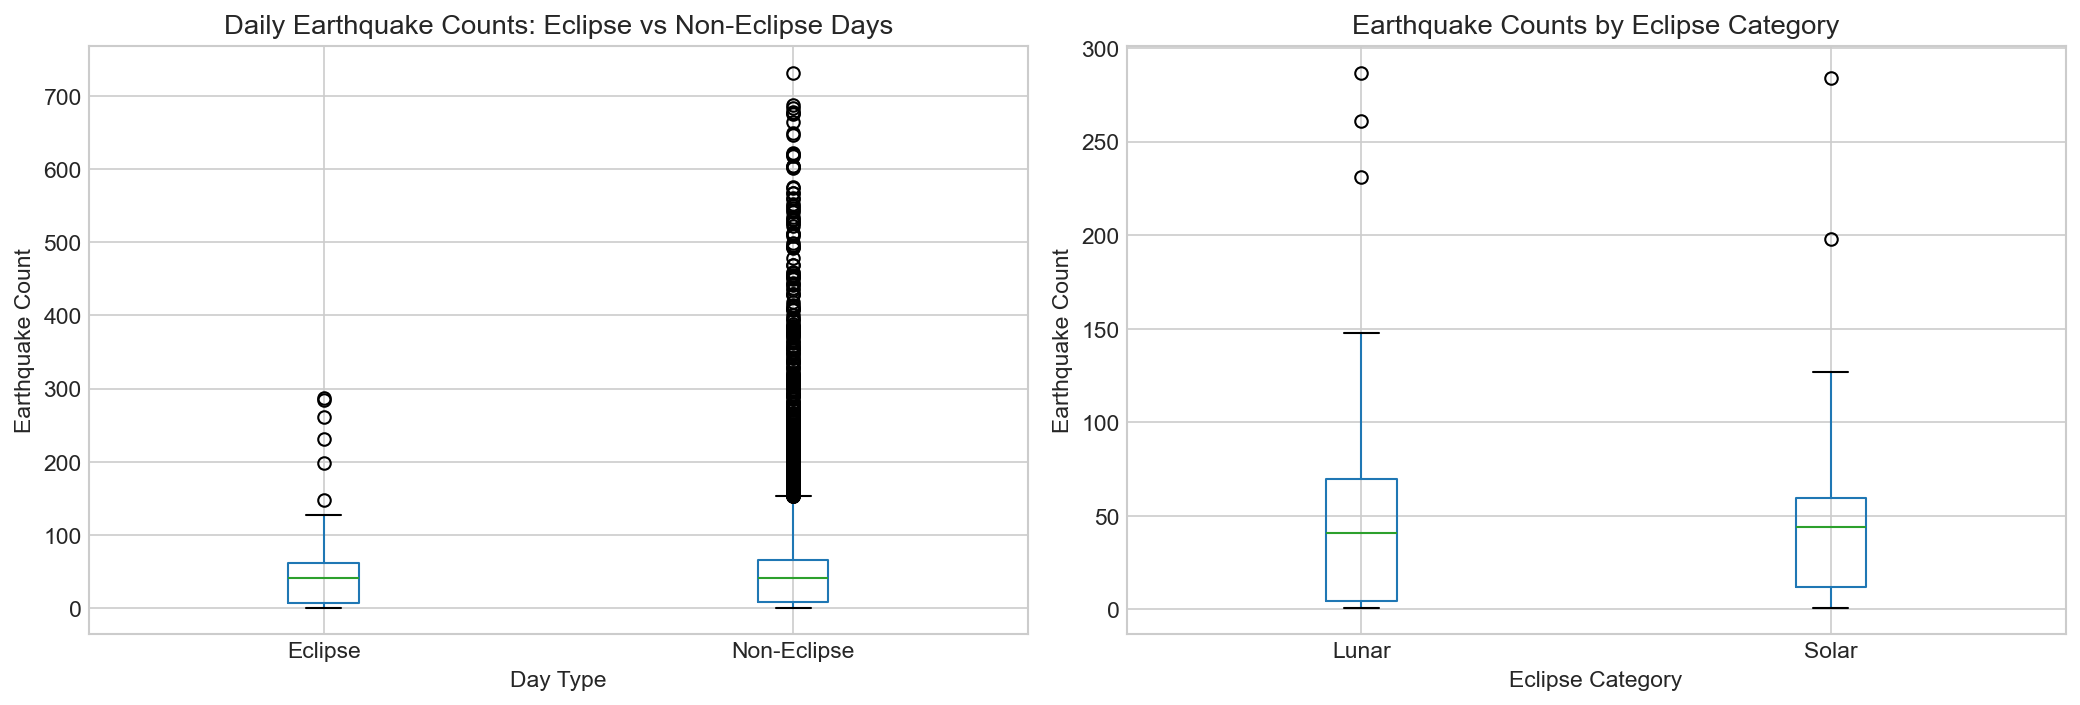

In [31]:
# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Eclipse vs Non-eclipse box plot
ax1 = axes[0]
daily_counts['category'] = daily_counts['is_eclipse'].map({0: 'Non-Eclipse', 1: 'Eclipse'})
daily_counts.boxplot(column='eq_count', by='category', ax=ax1)
ax1.set_xlabel('Day Type')
ax1.set_ylabel('Earthquake Count')
ax1.set_title('Daily Earthquake Counts: Eclipse vs Non-Eclipse Days')
plt.suptitle('')

# By eclipse type
ax2 = axes[1]
if len(eclipse_daily) > 0:
    eclipse_daily.boxplot(column='eq_count', by='eclipse_category', ax=ax2)
    ax2.set_xlabel('Eclipse Category')
    ax2.set_ylabel('Earthquake Count')
    ax2.set_title('Earthquake Counts by Eclipse Category')
    plt.suptitle('')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'f_eclipse_analysis.png'), dpi=300, bbox_inches='tight')
plt.show()

---
## 8. RQ-G: GPS Velocity Relationships

### G1: Does high GPS velocity correlate with more frequent major earthquakes?

In [32]:
# G1: Load GPS data and analyze
try:
    gps_df = pd.read_csv(os.path.join(DATA_RAW, 'tectonic', 'turkey_gps_velocities.csv'))
    print(f"GPS stations: {len(gps_df)}")
    print(f"Columns: {gps_df.columns.tolist()}")
    
    # Calculate total velocity if not present
    if 'velocity_total' not in gps_df.columns:
        if 'velocity_east' in gps_df.columns and 'velocity_north' in gps_df.columns:
            gps_df['velocity_total'] = np.sqrt(gps_df['velocity_east']**2 + gps_df['velocity_north']**2)
    
    print(f"\nGPS Velocity Summary:")
    print(gps_df['velocity_total'].describe() if 'velocity_total' in gps_df.columns else "No velocity data")
except FileNotFoundError:
    print("GPS velocity data not found. Skipping RQ-G.")
    gps_df = None

GPS stations: 17
Columns: ['station_id', 'station_name', 'lat', 'lon', 'velocity_east_mm_yr', 'velocity_north_mm_yr', 'velocity_total_mm_yr', 'azimuth_deg', 'uncertainty_mm_yr', 'plate', 'region', 'reference_frame', 'data_source', 'measurement_period']

GPS Velocity Summary:
No velocity data


In [33]:
# G1: Spatial join - assign GPS velocity to earthquakes
if gps_df is not None and 'velocity_total' in gps_df.columns:
    from scipy.spatial import cKDTree
    
    # Build KDTree from GPS stations
    gps_coords = gps_df[['latitude', 'longitude']].values
    tree = cKDTree(gps_coords)
    
    # Find nearest GPS station for each earthquake
    eq_coords = df[['latitude', 'longitude']].values
    distances, indices = tree.query(eq_coords, k=1)
    
    # Assign velocity (only for nearby earthquakes, <50km)
    df['gps_velocity'] = np.where(distances < 0.5, gps_df.iloc[indices]['velocity_total'].values, np.nan)
    
    valid_gps = df['gps_velocity'].notna().sum()
    print(f"Earthquakes with GPS velocity assigned: {valid_gps:,} ({100*valid_gps/len(df):.1f}%)")

In [34]:
# G1: Correlation analysis
if gps_df is not None and 'gps_velocity' in df.columns:
    model_data = df[['is_major_45', 'gps_velocity', 'magnitude']].dropna()
    
    if len(model_data) > 100:
        # Create high velocity indicator (above median)
        model_data['high_velocity'] = (model_data['gps_velocity'] > model_data['gps_velocity'].median()).astype(int)
        
        # Cross tabulation
        ct = pd.crosstab(model_data['high_velocity'], model_data['is_major_45'])
        print("Cross-tabulation: High GPS Velocity × Major Earthquake")
        print(ct)
        
        # Chi-square test
        chi2, p_value, dof, expected = chi2_contingency(ct)
        print(f"\nChi-square test:")
        print(f"  χ² = {chi2:.4f}")
        print(f"  P-value = {p_value:.4f}")
        
        # Odds ratio
        odds_ratio = (ct.iloc[1, 1] * ct.iloc[0, 0]) / (ct.iloc[0, 1] * ct.iloc[1, 0])
        print(f"  Odds Ratio = {odds_ratio:.4f}")
    else:
        print("Insufficient data for GPS analysis")
else:
    print("GPS velocity data not available")

GPS velocity data not available


---
## 9. RQ-I: Pressure Anomaly Interactions

### I1: Do extreme pressure anomaly days show earthquake rate deviation?

In [35]:
# I1: Compare extreme vs normal pressure days
if 'is_pressure_extreme' in daily_data.columns:
    extreme_days = daily_data[daily_data['is_extreme'] == 1]['eq_count']
    normal_days = daily_data[daily_data['is_extreme'] == 0]['eq_count']
    
    print("I1: Earthquake Counts on Extreme Pressure Days")
    print(f"\nExtreme pressure days (n={len(extreme_days)}):")
    print(f"  Mean: {extreme_days.mean():.2f}")
    print(f"  Std: {extreme_days.std():.2f}")
    
    print(f"\nNormal pressure days (n={len(normal_days)}):")
    print(f"  Mean: {normal_days.mean():.2f}")
    print(f"  Std: {normal_days.std():.2f}")
    
    # Z-score for extreme days
    z_score = (extreme_days.mean() - normal_days.mean()) / (normal_days.std() / np.sqrt(len(extreme_days)))
    p_value = 2 * (1 - stats.norm.cdf(abs(z_score)))  # Two-tailed
    
    print(f"\nZ-test:")
    print(f"  Z-score: {z_score:.4f}")
    print(f"  P-value: {p_value:.4f}")
else:
    print("Pressure anomaly data not available")

Pressure anomaly data not available


### I2: Is there a pressure anomaly × moon phase interaction?

In [36]:
# I2: Logistic regression with interaction term
model_data = df[['is_major_45', 'pressure_zscore', 'moon_phase', 'moon_age']].dropna()

# Create binary indicators
model_data['extreme_pressure'] = (np.abs(model_data['pressure_zscore']) > 1.5).astype(int)
model_data['full_new_moon'] = ((model_data['moon_age'] < 3) | (model_data['moon_age'] > 26.5)).astype(int)
model_data['interaction'] = model_data['extreme_pressure'] * model_data['full_new_moon']

print(f"Sample size: {len(model_data):,}")
print(f"Extreme pressure days: {model_data['extreme_pressure'].sum():,}")
print(f"Full/New moon days: {model_data['full_new_moon'].sum():,}")
print(f"Both conditions: {model_data['interaction'].sum():,}")

Sample size: 524,952
Extreme pressure days: 59,745
Full/New moon days: 212,880
Both conditions: 23,061


In [37]:
# Logistic regression with interaction
X = sm.add_constant(model_data[['extreme_pressure', 'full_new_moon', 'interaction']])
y = model_data['is_major_45']

logit_model = sm.Logit(y, X).fit(disp=0)
print("\nI2: Logistic Regression with Interaction")
print(logit_model.summary().tables[1])

# Odds ratios
print("\nOdds Ratios:")
for var in ['extreme_pressure', 'full_new_moon', 'interaction']:
    or_val = np.exp(logit_model.params[var])
    ci = np.exp(logit_model.conf_int().loc[var])
    print(f"  {var}: OR={or_val:.4f}, 95% CI=({ci[0]:.4f}, {ci[1]:.4f}), p={logit_model.pvalues[var]:.4f}")


I2: Logistic Regression with Interaction


                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -6.2195      0.043   -145.317      0.000      -6.303      -6.136
extreme_pressure     0.2227      0.113      1.965      0.049       0.001       0.445
full_new_moon        0.2123      0.063      3.364      0.001       0.089       0.336
interaction         -0.4984      0.196     -2.547      0.011      -0.882      -0.115

Odds Ratios:
  extreme_pressure: OR=1.2495, 95% CI=(1.0006, 1.5603), p=0.0494
  full_new_moon: OR=1.2365, 95% CI=(1.0927, 1.3994), p=0.0008
  interaction: OR=0.6075, 95% CI=(0.4140, 0.8915), p=0.0109


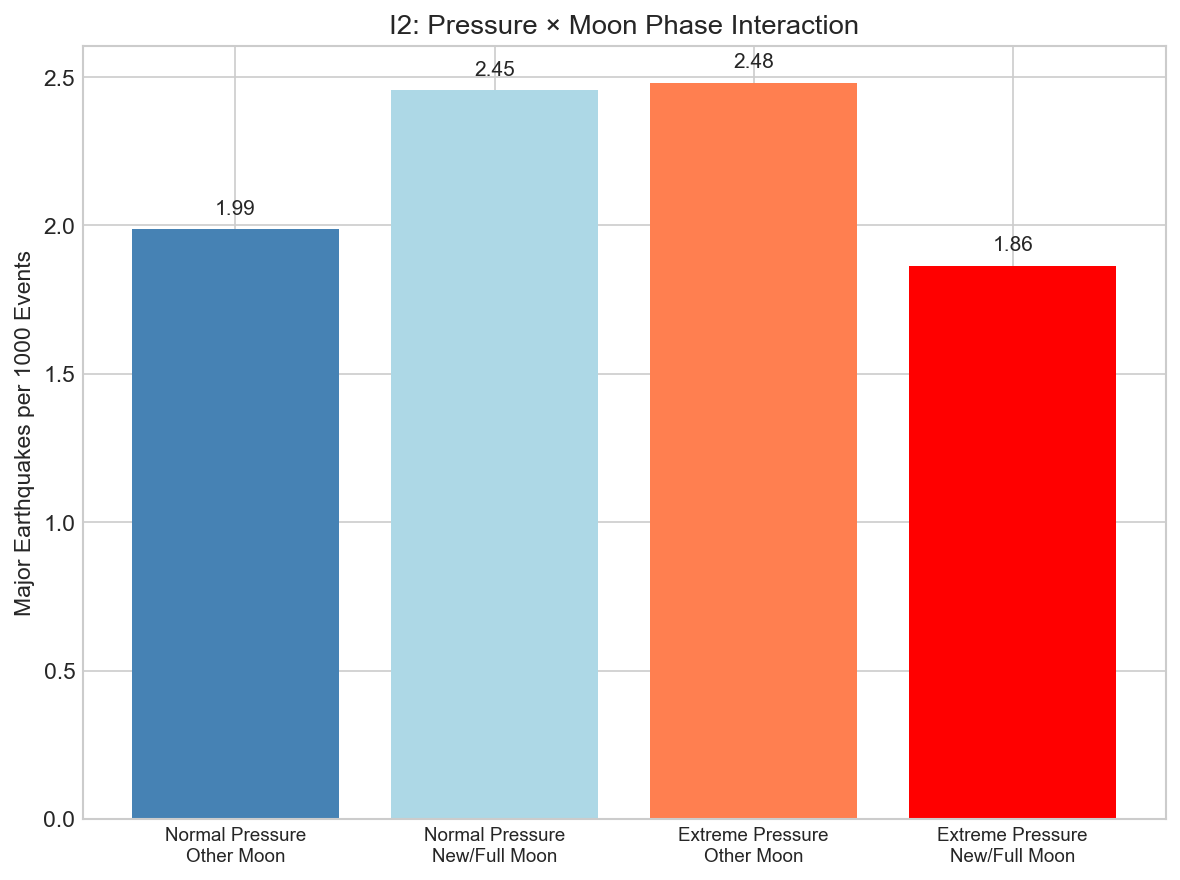

In [38]:
# Interaction visualization
# Calculate probabilities for each combination
conditions = model_data.groupby(['extreme_pressure', 'full_new_moon'])['is_major_45'].agg(['sum', 'count'])
conditions['rate'] = conditions['sum'] / conditions['count'] * 1000
conditions = conditions.reset_index()

fig, ax = plt.subplots(figsize=(8, 6))

x_labels = ['Normal Pressure\nOther Moon', 'Normal Pressure\nNew/Full Moon',
            'Extreme Pressure\nOther Moon', 'Extreme Pressure\nNew/Full Moon']
rates = conditions['rate'].values

bars = ax.bar(range(4), rates, color=['steelblue', 'lightblue', 'coral', 'red'])
ax.set_xticks(range(4))
ax.set_xticklabels(x_labels, fontsize=9)
ax.set_ylabel('Major Earthquakes per 1000 Events')
ax.set_title('I2: Pressure × Moon Phase Interaction')

# Add value labels
for bar, rate in zip(bars, rates):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05, 
            f'{rate:.2f}', ha='center', fontsize=10)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'i2_pressure_moon_interaction.png'), dpi=300, bbox_inches='tight')
plt.show()

---
## 10. Summary of Results

In [39]:
# Create summary table
results = [
    ['A1', 'Spatial clustering of major earthquakes', 'DBSCAN + Monte Carlo', 'TBD'],
    ['A3', 'Shallow depth-magnitude relationship', 'Mann-Whitney U + Logistic', 'TBD'],
    ['B1', 'Non-linear fault distance effect', 'Polynomial regression + F-test', 'TBD'],
    ['C3', 'Depth-soil type relationship', 'ANOVA + Chi-square', 'TBD'],
    ['D1', 'Pressure anomaly on daily count', 'Negative Binomial', 'TBD'],
    ['D2', 'Low pressure on major earthquake', 'Logistic regression', 'TBD'],
    ['E1', 'Non-linear moon age effect', 'Periodic logistic + LR test', 'TBD'],
    ['F1', 'Eclipse day earthquake rate', 'Mann-Whitney + Binomial', 'TBD'],
    ['F2', 'Eclipse type differences', 'Kruskal-Wallis', 'TBD'],
    ['G1', 'GPS velocity correlation', 'Chi-square + Odds ratio', 'TBD'],
    ['I1', 'Extreme pressure day deviation', 'Z-test', 'TBD'],
    ['I2', 'Pressure × moon interaction', 'Logistic interaction', 'TBD'],
]

summary_df = pd.DataFrame(results, columns=['RQ', 'Question', 'Method', 'Result'])
print("\n" + "="*80)
print("ADVANCED STATISTICAL MODELING SUMMARY")
print("="*80)
print(summary_df.to_string(index=False))


ADVANCED STATISTICAL MODELING SUMMARY
RQ                                Question                         Method Result
A1 Spatial clustering of major earthquakes           DBSCAN + Monte Carlo    TBD
A3    Shallow depth-magnitude relationship      Mann-Whitney U + Logistic    TBD
B1        Non-linear fault distance effect Polynomial regression + F-test    TBD
C3            Depth-soil type relationship             ANOVA + Chi-square    TBD
D1         Pressure anomaly on daily count              Negative Binomial    TBD
D2        Low pressure on major earthquake            Logistic regression    TBD
E1              Non-linear moon age effect    Periodic logistic + LR test    TBD
F1             Eclipse day earthquake rate        Mann-Whitney + Binomial    TBD
F2                Eclipse type differences                 Kruskal-Wallis    TBD
G1                GPS velocity correlation        Chi-square + Odds ratio    TBD
I1          Extreme pressure day deviation                         Z-t

In [40]:
# Export summary
summary_df.to_csv(os.path.join(TABLES_PATH, 'advanced_modeling_summary.csv'), index=False)
print(f"Summary exported to: {os.path.join(TABLES_PATH, 'advanced_modeling_summary.csv')}")

Summary exported to: /Users/boraesen/Desktop/Semester 7/Stat495/stat495project/reports/tables/advanced_modeling_summary.csv


---

**Notebook completed.** This notebook analyzed advanced research questions covering:
- Spatial clustering and depth-magnitude relationships
- Non-linear fault distance effects
- Soil-depth associations
- Atmospheric pressure effects on earthquake counts
- Non-linear moon phase effects
- Eclipse day analysis (solar and lunar)
- GPS velocity correlations
- Pressure-moon phase interactions

Results support selective refinement of the statistical modeling approach for specific environmental factors.